In [1]:
import math
import numpy as np
from pathlib import Path
from random import randint

from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from collections import namedtuple
import random
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Subset
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from einops import rearrange, reduce, repeat
from tqdm.auto import tqdm
from torch.utils.data import random_split
import minerl
import os
from minerl.data import BufferedBatchIter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from CDDPM2 import ActionGeneratorCNN, ActionGaussianDiffusion, TimeEmbedding, default
from baseline import ActionCNN

/root/miniconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [34]:
def extract_features(diffusion_model, data_loader, device):
    diffusion_model = diffusion_model.to(device)
    diffusion_model.eval()
    extracted_features = []
    with torch.no_grad():
        for images, actions in tqdm(data_loader, desc="Extracting features"):
            images = images.to(device)
            actions = actions.to(device)
            # 假设使用最后一个时间步骤作为示例
            timesteps = torch.full((images.size(0),), diffusion_model.num_timesteps - 1, device=device)
            # 使用模型进行特征提取
            features = diffusion_model.model(images, actions, timesteps).detach().cpu().numpy()
            extracted_features.append(features)
    return np.concatenate(extracted_features, axis=0)

def plot_tsne(features, name, perplexity=30, n_components=2, init='pca', random_state=23):
    tsne = TSNE(perplexity=perplexity, n_components=n_components, init=init, random_state=random_state)
    transformed_features = tsne.fit_transform(features)
    plt.figure(figsize=(10, 6))
    plt.scatter(transformed_features[:, 0], transformed_features[:, 1], marker='.', alpha=0.7)
    plt.title(name)
    plt.show()

def plot_pca(features, n_components=2):
    pca = PCA(n_components=n_components)
    transformed_features = pca.fit_transform(features)
    plt.figure(figsize=(10, 6))
    plt.scatter(transformed_features[:, 0], transformed_features[:, 1], marker='.', alpha=0.7)
    plt.title('PCA projection of the image features')
    plt.show()

def plot_umap(features, n_neighbors=15, min_dist=0.1, n_components=2):
    umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    umap_result = umap_reducer.fit_transform(features)
    plt.figure(figsize=(10, 6))
    plt.scatter(umap_result[:, 0], umap_result[:, 1], marker='.', alpha=0.7)
    plt.title('UMAP projection of the image features')
    plt.show()

In [3]:
def encode_action(action):
    # 离散动作直接使用值
    discrete_actions = np.array([
        action['attack'], action['back'], action['forward'],
        action['jump'], action['left'], action['right'],
        action['sneak'], action['sprint']
    ]).flatten()  # 确保是一维数组

    # 处理连续动作：'camera'，直接使用数值
    # 由于camera的范围是[-180, 180]，我们可以将其标准化到[-1, 1]以提高稳定性
    camera_actions = np.array(action['camera']).flatten() / 180.0  # 确保是一维数组，并进行标准化

    # 处理枚举动作：'place'
    # 我们将'dirt'映射为[1]，'none'映射为[0]
    place_action = np.array([1]) if action['place'] == 'dirt' else np.array([0])

    # 将所有编码后的动作拼接为一个向量
    encoded_action = np.concatenate([discrete_actions, camera_actions, place_action])

    return encoded_action

class MineRLDataset(Dataset):
    def __init__(self, environment='MineRLNavigate-v0', transform=None, img_size=64, max_samples=10000):
        self.img_size = img_size
        self.data = minerl.data.make(environment)
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.samples = []

        iterator = BufferedBatchIter(self.data)
        count = 0  # 初始化计数器
        for current_state, action, _, _, _ in iterator.buffered_batch_iter(batch_size=1, num_epochs=1):
            if count >= max_samples:  # 检查是否达到了最大样本数
                break  # 如果是，则退出循环
            pov_image = current_state['pov'][0]  # 取序列的第一个图像
            encoded_action = encode_action(action)
            self.samples.append((pov_image, encoded_action))
            count += 1  # 更新计数器

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pov_image, encoded_action = self.samples[idx]
        pov_image = self.transform(pov_image)  # 应用预处理转换
        encoded_action = torch.tensor(encoded_action, dtype=torch.float32)
        return pov_image, encoded_action

os.environ['MINERL_DATA_ROOT'] = '/root/autodl-tmp'
dataset = MineRLDataset()

100%|██████████| 1500/1500 [00:00<00:00, 5175.87it/s]


In [4]:
n_samples = 500  # 你可以根据需要调整这个数值

# 从原始数据集中随机选择n张图片
indices = random.sample(range(len(dataset)), n_samples)

# 创建一个新的数据集，仅包含选中的图片
newdataset = Subset(dataset, indices)

data_loader = DataLoader(newdataset, batch_size=32, shuffle=True)

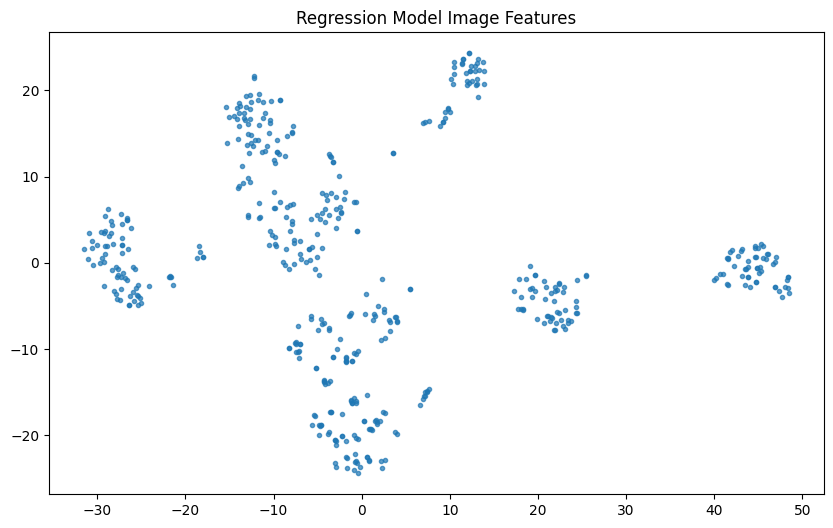

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载已训练的模型
model_path = '/root/CDDPM/results_regre3/best_model.pth'
checkpoint = torch.load(model_path, map_location=device)
model = ActionCNN().to(device)

model.load_state_dict(checkpoint)

features = []
for img, _ in data_loader:
    img_features = model.extract_features(img.to(device))
    features.append(img_features.cpu().detach().numpy())
features = np.concatenate(features, axis=0)
# 使用t-SNE分析图像特征
plot_tsne(features, 'Regression Model Image Features')

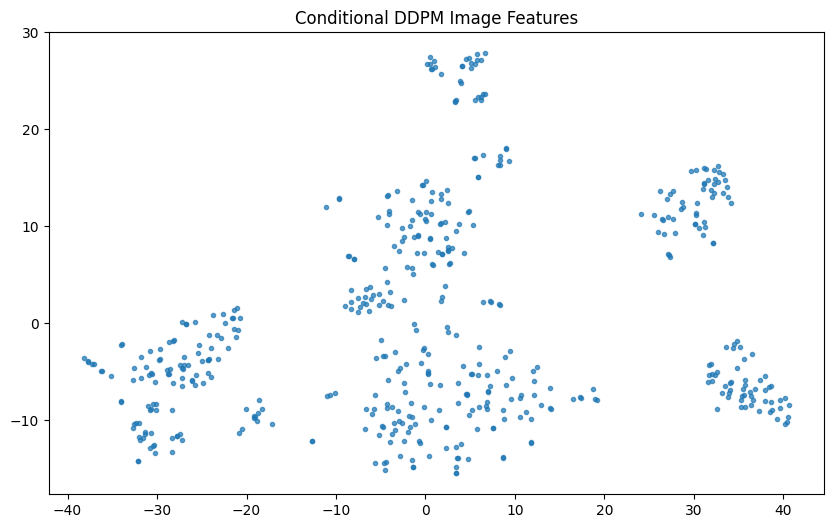

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载已训练的模型
model_path = '/root/CDDPM/results8/model_best.pth'
checkpoint = torch.load(model_path, map_location=device)
model = ActionGeneratorCNN(dim=64, dim_mults=(1, 2, 4, 8), channels=3, action_dim=11).to(device)
diffusion_model = ActionGaussianDiffusion(model=model, image_size=64, shape=(1, 11), timesteps=1000,
                                              sampling_timesteps=250, objective='pred_x0').to(device)
diffusion_model.load_state_dict(checkpoint['model_state_dict'])

features = []
for img, _ in data_loader:
    img_features = diffusion_model.extract_image_features(img.to(device))
    features.append(img_features.cpu().detach().numpy())
features = np.concatenate(features, axis=0)
# 使用t-SNE分析图像特征
plot_tsne(features, 'Conditional DDPM Image Features')

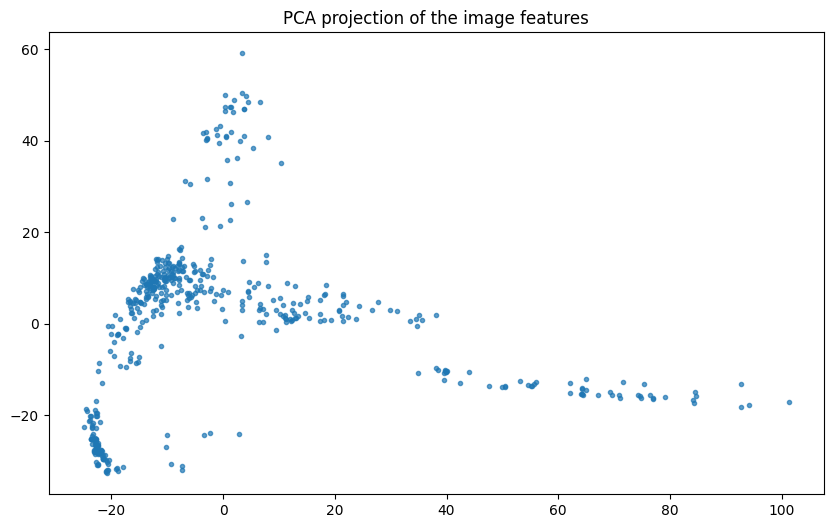

In [25]:
# 使用PCA分析图像特征
plot_pca(features)